<center>МИНИСТЕРСТВО НАУКИ И ВЫСШЕГО ОБРАЗОВАНИЯ РОССИЙСКОЙ ФЕДЕРАЦИИ </center>
<center>ФЕДЕРАЛЬНОЕ ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ ОБРАЗОВАТЕЛЬНОЕ УЧРЕЖДЕНИЕ ВЫСШЕГО ОБРАЗОВАНИЯ </center>
<center>«НОВОСИБИРСКИЙ ГОСУДАРСТВЕННЫЙ ТЕХНИЧЕСКИЙ УНИВЕРСИТЕТ»</center>
<center>Кафедра Вычислительной техники </center>
<br>
<center> <b> <font size="5">  ОТЧЁТ </font>  </b>  </center>   
<center><font size="3">по лабораторной работе №1</font></center>
<center><font size="3">по дисциплине: «Системы искусственного интеллекта и машинное обучение» </font></center>
<br>

Выполнили:
- _ _ _ Дмитриченко Д.А. _ _ _
- _ _ _ Опрышко М.А. _ _ _

Проверил: _ _ _ Осипенко И.В. _ _ _

<center>  Новосибирск, 2025  </center>


In [166]:
# Python 3.10
import pandas as pd
import numpy  as np
import category_encoders as ce

import sklearn
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns

In [167]:
df = pd.read_csv(
    '../Data/Moscow_Housing_Price_Dataset_nan_24.csv', # путь к файлу через символ "/", (используйте автодополнение)
    sep       = ',' ,
    decimal   = '.' ,
    header    = 0,  # если заголовки в нулевой строке таблицы,
        #  header=None если заголовки отсутствуют
    #na_values =  ['???', ' '], # доп. символы для обозначения отсутствующих значений
)

df[0:2] # отобразить первые строки таблицы df

,Price,Apartment type,Metro station,Minutes to metro,Region,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors,Renovation
0,>??<,Secondary,Опалиха,6.0,Moscow region,1.0,30.6,11.1,8.5,25.0,25,Cosmetic
1,9000000.0,Secondary,Павшино,2.0,Moscow region,1.0,49.2,20.0,10.0,6.0,15,European-style renovation


In [168]:
print  (df.shape)
nrow = df.shape[0]
ncol = df.shape[1]
print ("Итого: " + str(nrow) + " записи, " + str(ncol) + " столбец (признак).")

(22676, 12)
Итого: 22676 записи, 12 столбец (признак).


In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22676 entries, 0 to 22675
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             22664 non-null  object 
 1   Apartment type    22674 non-null  object 
 2   Metro station     22675 non-null  object 
 3   Minutes to metro  22676 non-null  float64
 4   Region            22676 non-null  object 
 5   Number of rooms   22675 non-null  float64
 6   Area              22676 non-null  float64
 7   Living area       22676 non-null  float64
 8   Kitchen area      22674 non-null  float64
 9   Floor             22676 non-null  float64
 10  Number of floors  22676 non-null  int64  
 11  Renovation        22675 non-null  object 
dtypes: float64(6), int64(1), object(5)
memory usage: 2.1+ MB


In [170]:
df['Price'] = pd.to_numeric(
    df['Price'],      # Входной набор значений
    errors = 'coerce' # режим замены на NaN
)

In [171]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,22663.0,3.609019e+07,8.271023e+07,1150000.0,7066664.0,11343200.0,24753001.50,2.455020e+09
Minutes to metro,22676.0,1.188860e+01,6.204457e+00,0.0,7.0,11.0,15.00,6.000000e+01
Number of rooms,22675.0,2.043131e+00,1.523620e+00,0.0,1.0,2.0,3.00,1.200000e+01
Area,22676.0,7.196683e+01,6.836861e+01,6.0,37.4,53.3,77.14,1.117000e+03
Living area,22676.0,3.851795e+01,3.812428e+01,2.0,17.6,28.5,43.20,5.668000e+02
Kitchen area,22674.0,1.259406e+01,7.728284e+00,1.0,8.6,10.6,14.50,1.220000e+02
Floor,22676.0,9.190466e+00,7.549996e+00,1.0,4.0,8.0,13.00,9.200000e+01
Number of floors,22676.0,1.655609e+01,9.779297e+00,1.0,11.0,16.0,20.00,9.700000e+01


In [172]:
# описание для НЕ числовых значений, при их наличии
if (df.dtypes == 'object').sum() >0:
    print(df.describe(include=['object', 'bool']).T )

                count unique                top   freq
Apartment type  22674      2          Secondary  13151
Metro station   22675    547  Красногвардейская   2697
Region          22676      2             Moscow  16113
Renovation      22675      4           Cosmetic  12788


## Изменение названия признаков

In [173]:
df.columns

Index(['Price', 'Apartment type', 'Metro station', 'Minutes to metro',
       'Region', 'Number of rooms', 'Area', 'Living area', 'Kitchen area',
       'Floor', 'Number of floors', 'Renovation'],
      dtype='object')

## Пропущенные значения

In [174]:
print ( df.isna().sum() ) # используем print для компактного вывода

Price               13
Apartment type       2
Metro station        1
Minutes to metro     0
Region               0
Number of rooms      1
Area                 0
Living area          0
Kitchen area         2
Floor                0
Number of floors     0
Renovation           1
dtype: int64


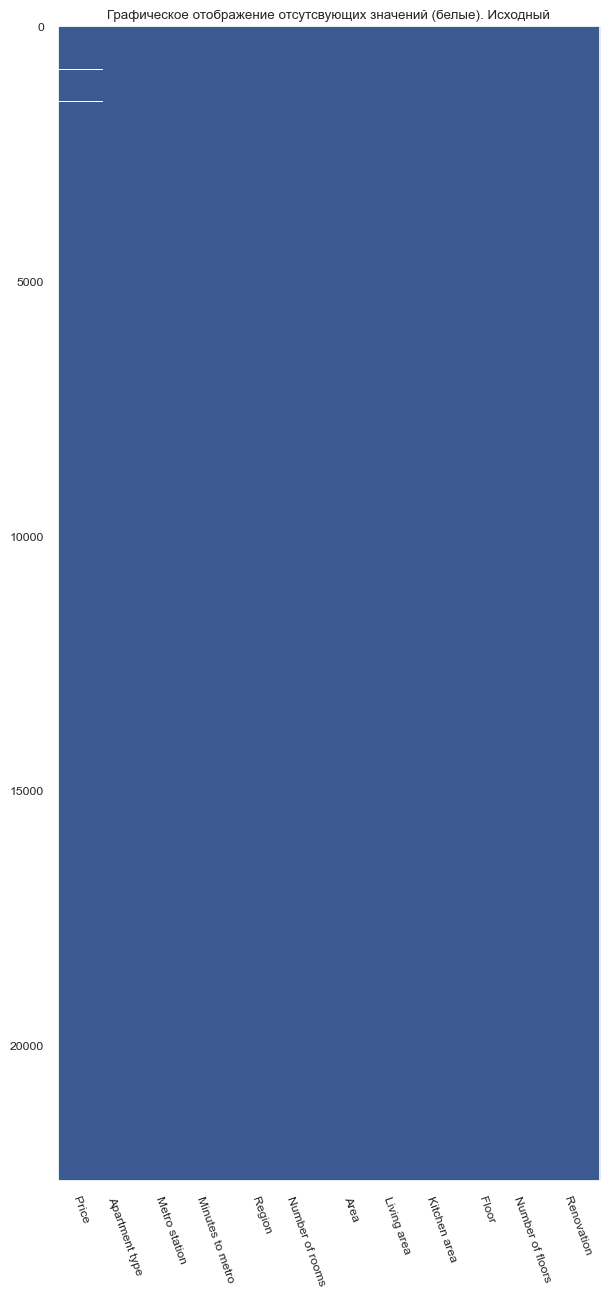

In [175]:
from matplotlib.colors import ListedColormap
def plotTableNA(dataF, addToTilte =""):
    '''  Функция для построения графика отображение отсутсвующих значений'''
    if   len(dataF.columns)> 20:   K = 3
    elif len(dataF.columns)== 1:   K = 1
    else:                          K = 1.7

    figSizeH = 15        # размер полотна, высота
    figSizeW =int(len(dataF.columns)/K) # размер полотна, ширина
    fig, ax = plt.subplots( figsize=(figSizeW, figSizeH)) # создать полотно для рисования, figsize-размер в дюймах

    # отрисовать матрицу значений функцией imshow. Применяется цветовая палитра
    plt.imshow( dataF.isna(),
                cmap = ListedColormap([ '#3B5A92', 'white', ]), # выбор цветовой шкалы, аналог cm.get_cmap('jet'),
                aspect='auto',  # ‘auto’ | ‘equal’ | scalar]    # режим соотнощения сторон
                interpolation= 'none',)                         # отключить размытие
    ax.set_xticks(np.arange(len(dataF.columns)))
    ax.set_xticklabels(dataF.columns, rotation=-70,)
    plt.title("Графическое отображение отсутсвующих значений (белые). "+ addToTilte)
    plt.grid(False) # Сетка
#-------------------------------------
# Вызов функции с указанием параметров
plotTableNA( dataF=df, addToTilte="Исходный" )

In [176]:
print("Размер исходного DataFrame", df.shape)
print("Вар.3.1. Размер при исключении по строкам",  df.dropna(axis='index', how='any').shape)
print("Вар.3.2. Размер при исключении по столбцам", df.dropna(axis='columns', how='any').shape)

Размер исходного DataFrame (22676, 12)
Вар.3.1. Размер при исключении по строкам (22656, 12)
Вар.3.2. Размер при исключении по столбцам (22676, 6)


In [177]:
df = df.dropna(axis='index', how='any')
print("Размер таблицы после исключения пропусков", df.shape)

Размер таблицы после исключения пропусков (22656, 12)


In [178]:
print ("Итого: " + str(df.shape[0]) + " записи, " + str(df.shape[1]) + " столбец (признак).")

Итого: 22656 записи, 12 столбец (признак).


### Замена значений (mapping) + One-Hot encoding

Нужно использовать mapping, потому что иначе информация была бы избыточной (ловушка фиктивных переменных)

In [179]:
df.shape

(22656, 12)

In [180]:
# описание для НЕ числовых значений, при их наличии
if (df.dtypes == 'object').sum() >0:
    print(df.describe(include=['object', 'bool']).T )

                count unique                top   freq
Apartment type  22656      2          Secondary  13134
Metro station   22656    547  Красногвардейская   2696
Region          22656      2             Moscow  16099
Renovation      22656      4           Cosmetic  12780


In [181]:
df['Apartment type'].unique() # получить массив уникальных значений в столбце

array(['Secondary', 'New building'], dtype=object)

In [182]:
# применить карту соотвествий имеющихся и новых значений. Тип данных результата - int, т.к. замена на числа
df['Apartment_type_Digit'] = df['Apartment type'].map(
    {
        'Secondary'  : 0,
        'New building' : 1,
    }
)
df[[ 'Apartment type' , 'Apartment_type_Digit']] [:2]

,Apartment type,Apartment_type_Digit
1,Secondary,0
2,Secondary,0


In [183]:
df.shape

(22656, 13)

In [184]:
df['Region'].unique() # получить массив уникальных значений в столбце

array(['Moscow region', 'Moscow'], dtype=object)

In [185]:
# применить карту соотвествий имеющихся и новых значений. Тип данных результата - int, т.к. замена на числа
df['Region_Digit'] = df['Region'].map(
    {
        'Moscow region'  : 0,
        'Moscow' : 1,
    }
)
df[[ 'Region' , 'Region_Digit']] [:2]

,Region,Region_Digit
1,Moscow region,0
2,Moscow region,0


In [186]:
df.shape

(22656, 14)

### One-Hot encoding

One-Hot Encoding (OHE) — это метод кодирования категориальных признаков в числовой вид, при котором для каждого уникального значения признака создаётся отдельный бинарный (0/1) столбец.

Модели машинного обучения (линейная регрессия, логистическая регрессия, деревья решений и др.) работают только с числами. OHE позволяет представить категории так, чтобы модель видела их как набор независимых бинарных признаков.

In [187]:
df['Renovation'].unique() # получить массив уникальных значений в столбце

array(['European-style renovation', 'Cosmetic', 'Without renovation',
       'Designer'], dtype=object)

In [188]:
objColNames    = ['Renovation'] # названия признаков в исходной таблицы в виде списка
prefixColNames = ['Renovation_N']       # сокращенные названия признаков для новой таблицы в виде списка

df_dummies = pd.get_dummies(
    data   = df[objColNames],  # таблица с признаками для кодирования
    prefix = prefixColNames,   # сокращенные приставки к новым столбцам
    dtype  = int,              # результат сравнения в виде целых чисел {0,1}
)

df = pd.concat([df, df_dummies], axis=1)
df_dummies[:3] # осмотрим перые строки новой таблицы

,Renovation_N_Cosmetic,Renovation_N_Designer,Renovation_N_European-style renovation,Renovation_N_Without renovation
1,0,0,1,0
2,1,0,0,0
3,0,0,1,0


In [189]:
df.shape

(22656, 18)

### Binary Encoding

Двоичное кодирование (Binary Encoding) — это промежуточный метод между One-Hot и Label Encoding:

1. Каждой категории присваивается номер (1, 2, 3, ...).

2. Этот номер переводится в двоичную систему.

3. Каждая цифра двоичного числа занимает отдельный столбец (0/1).

In [190]:
# список категориальных признаков
cat_features = ['Metro station']

# инициализация двоичного кодировщика
encoder = ce.BinaryEncoder(cols=cat_features)

# преобразуем данные
df_binary = encoder.fit_transform(df)

print(df_binary.head())

        Price Apartment type  Metro station_0  Metro station_1  \
1   9000000.0      Secondary                0                0   
2  11090000.0      Secondary                0                0   
3   8300000.0      Secondary                0                0   
4   6450000.0      Secondary                0                0   
5   7150000.0      Secondary                0                0   

   Metro station_2  Metro station_3  Metro station_4  Metro station_5  \
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   
5                0                0                0                0   

   Metro station_6  Metro station_7  ...  Kitchen area  Floor  \
1                0                0  ...          10.0    6.0   
2                0                

In [191]:
df_binary.shape

(22656, 27)

Между ценой и ремонтом прослеживается связь, это можно видеть на гистограмме

(0.0, 100000000.0)

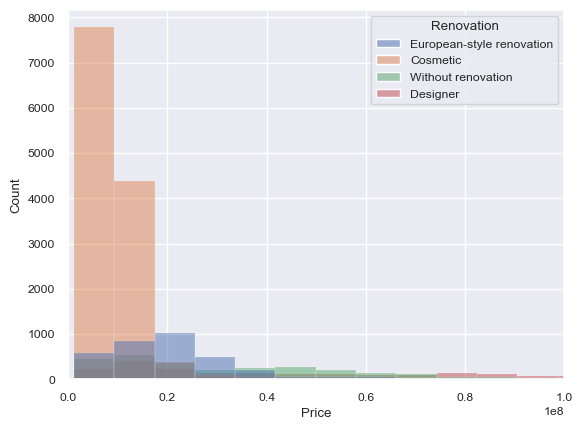

In [192]:
sns.histplot(df, x="Price", hue="Renovation")
plt.xlim([0, 100_000_000])


## Формирование таблицы с строго числовыми значениями

In [193]:
# описание для числовых значений. Оператор ".T" транспонирует матрицу для удобства чтения
df_binary.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,22656.0,3.608730e+07,8.271639e+07,1150000.0,7065574.5,11343200.0,24751500.75,2.455020e+09
Metro station_0,22656.0,7.812500e-02,2.683741e-01,0.0,0.0,0.0,0.00,1.000000e+00
Metro station_1,22656.0,7.341102e-01,4.418156e-01,0.0,0.0,1.0,1.00,1.000000e+00
Metro station_2,22656.0,3.162518e-01,4.650227e-01,0.0,0.0,0.0,1.00,1.000000e+00
Metro station_3,22656.0,3.852843e-01,4.866731e-01,0.0,0.0,0.0,1.00,1.000000e+00
Metro station_4,22656.0,4.065148e-01,4.911936e-01,0.0,0.0,0.0,1.00,1.000000e+00
Metro station_5,22656.0,5.703566e-01,4.950361e-01,0.0,0.0,1.0,1.00,1.000000e+00
Metro station_6,22656.0,4.688824e-01,4.990418e-01,0.0,0.0,0.0,1.00,1.000000e+00
Metro station_7,22656.0,4.157398e-01,4.928600e-01,0.0,0.0,0.0,1.00,1.000000e+00
Metro station_8,22656.0,6.168785e-01,4.861582e-01,0.0,0.0,1.0,1.00,1.000000e+00


In [194]:
# описание для НЕ числовых значений, при их наличии
if (df_binary.dtypes == 'object').sum() >0:
    print(df_binary.describe(include=['object', 'bool']).T )

                count unique        top   freq
Apartment type  22656      2  Secondary  13134
Region          22656      2     Moscow  16099
Renovation      22656      4   Cosmetic  12780


In [195]:
# список названий числовых признаков исходной таблицы
digitColName = df_binary.select_dtypes(include=['number']).columns.tolist()

df_digital = df_binary [digitColName]
df_digital

,Price,Metro station_0,Metro station_1,Metro station_2,Metro station_3,Metro station_4,Metro station_5,Metro station_6,Metro station_7,Metro station_8,...,Living area,Kitchen area,Floor,Number of floors,Apartment_type_Digit,Region_Digit,Renovation_N_Cosmetic,Renovation_N_Designer,Renovation_N_European-style renovation,Renovation_N_Without renovation
1,9000000.0,0,0,0,0,0,0,0,0,0,...,20.0,10.0,6.0,15,0,0,0,0,1,0
2,11090000.0,0,0,0,0,0,0,0,0,1,...,16.2,13.1,10.0,25,0,0,1,0,0,0
3,8300000.0,0,0,0,0,0,0,0,0,1,...,16.0,11.0,12.0,33,0,0,0,0,1,0
4,6450000.0,0,0,0,0,0,0,0,1,0,...,15.2,4.0,5.0,5,0,0,0,0,0,1
5,7150000.0,0,0,0,0,0,0,0,1,0,...,18.0,8.0,8.0,18,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22671,4768792.0,1,0,0,0,1,0,0,0,1,...,13.0,5.0,4.0,17,1,0,1,0,0,0
22672,5900000.0,0,1,0,0,1,0,1,1,1,...,10.1,12.2,11.0,15,1,0,1,0,0,0
22673,3700000.0,1,0,0,0,1,0,0,0,1,...,15.0,8.1,17.0,17,1,0,1,0,0,0
22674,5768869.0,0,1,1,0,0,1,1,1,0,...,22.0,6.6,12.0,14,1,0,1,0,0,0


In [196]:
df_digital.shape

(22656, 24)

# Выбор целевого значения и признаков для анализа данных

In [197]:
corr_df = df_digital.corr(method='pearson')
corr_df

,Price,Metro station_0,Metro station_1,Metro station_2,Metro station_3,Metro station_4,Metro station_5,Metro station_6,Metro station_7,Metro station_8,...,Living area,Kitchen area,Floor,Number of floors,Apartment_type_Digit,Region_Digit,Renovation_N_Cosmetic,Renovation_N_Designer,Renovation_N_European-style renovation,Renovation_N_Without renovation
Price,1.000000,0.025040,-0.239766,-0.057421,-0.017480,0.063074,0.020773,-0.007365,0.084362,-0.076715,...,0.710826,0.583003,0.019423,-0.021844,-0.287374,0.224475,-0.363834,0.374311,-0.008348,0.161800
Metro station_0,0.025040,1.000000,-0.483714,-0.197983,-0.230469,0.208765,-0.283249,-0.211234,-0.183161,0.161756,...,0.012839,0.058076,-0.008552,-0.072332,0.198619,-0.300198,0.126555,-0.030871,-0.073842,-0.072061
Metro station_1,-0.239766,-0.483714,1.000000,0.232267,0.240379,-0.145256,0.259300,0.149457,-0.003767,0.021388,...,-0.179465,-0.238953,-0.059487,-0.077858,0.241218,0.053657,0.224252,-0.191560,-0.028626,-0.102219
Metro station_2,-0.057421,-0.197983,0.232267,1.000000,-0.119279,-0.197241,0.197573,0.207982,-0.044638,0.003527,...,-0.049168,-0.046412,-0.022006,-0.144959,0.089928,0.110862,0.095192,-0.049009,-0.025019,-0.061321
Metro station_3,-0.017480,-0.230469,0.240379,-0.119279,1.000000,-0.190644,0.206183,-0.283499,-0.142801,0.146314,...,-0.001628,-0.069825,-0.041262,0.076550,0.011819,-0.198334,0.017388,-0.026367,0.025106,-0.025600
Metro station_4,0.063074,0.208765,-0.145256,-0.197241,-0.190644,1.000000,-0.363963,-0.026364,0.182702,-0.112284,...,0.054981,0.093840,0.003639,0.021246,-0.081711,0.175470,-0.130161,0.067208,0.068847,0.047002
Metro station_5,0.020773,-0.283249,0.259300,0.197573,0.206183,-0.363963,1.000000,-0.005342,-0.152184,0.147589,...,0.011992,-0.047426,0.018871,0.020386,0.126097,-0.116431,0.070458,-0.007960,-0.063526,-0.025407
Metro station_6,-0.007365,-0.211234,0.149457,0.207982,-0.283499,-0.026364,-0.005342,1.000000,0.243459,-0.199239,...,-0.005143,0.012783,0.042116,-0.034632,-0.104771,0.398164,-0.045897,0.004402,0.019106,0.040890
Metro station_7,0.084362,-0.183161,-0.003767,-0.044638,-0.142801,0.182702,-0.152184,0.243459,1.000000,-0.359113,...,0.082892,0.072104,-0.019134,-0.000411,-0.245605,0.226911,-0.177924,0.083363,0.076686,0.090996
Metro station_8,-0.076715,0.161756,0.021388,0.003527,0.146314,-0.112284,0.147589,-0.199239,-0.359113,1.000000,...,-0.047354,-0.045973,-0.015363,-0.014167,0.324112,-0.269705,0.191021,-0.079821,-0.098343,-0.090202


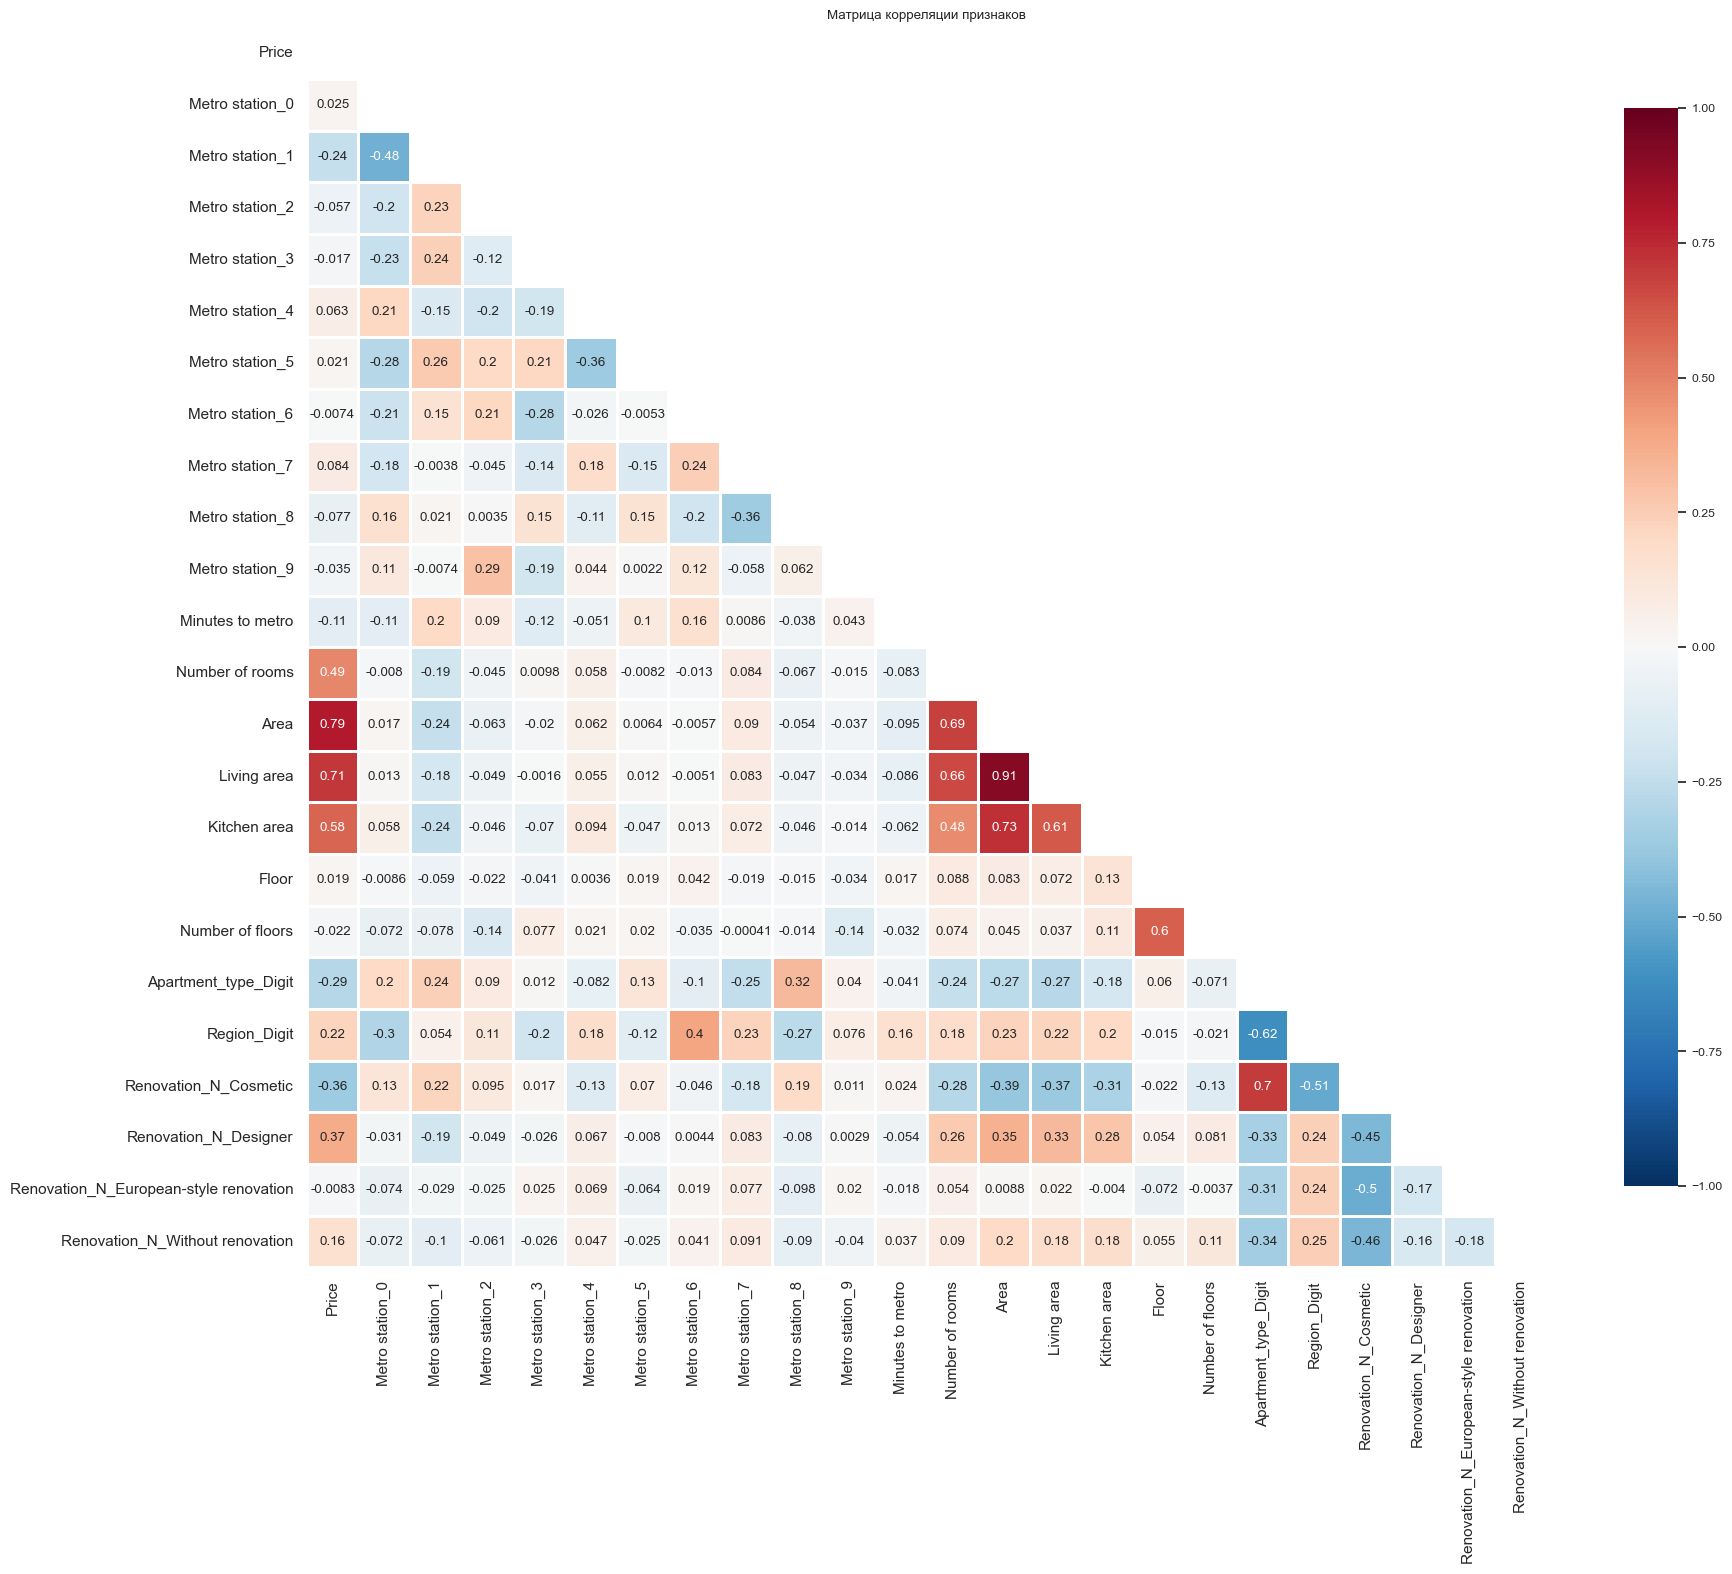

In [198]:
sns.set(style="white")# цвет фона

# построить "маску" для отображения только половины корреляционной матрицы
mask = np.zeros_like(corr_df, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(20,20))
sns.set(font_scale=0.8) # размер шрифта

# Построить тепловую карту
sns.heatmap(
    ##################
    data=corr_df,   ### <<<- объект-матрица корреляции
    ##################
    vmin=-1, vmax=1, center=0,
    annot=True,
    cmap = 'RdBu_r',
    mask=mask,   # применить маску
    square=True, # форма ячейки - квадрат
    linewidths=1.0, # зазор между ячейки
    cbar_kws={"shrink": .7}  # уменьшить размер легенды
)
plt.title(u'Матрица корреляции признаков');

Получим столбец для целевого признака.

In [199]:
# Последовательное применение операции:
# - получить единственный столбец,
# - получить абсолютные значения,
# - отсортировать
corr_df[['Price']].abs().sort_values(by="Price")

,Price
Metro station_6,0.007365
Renovation_N_European-style renovation,0.008348
Metro station_3,0.017480
Floor,0.019423
Metro station_5,0.020773
Number of floors,0.021844
Metro station_0,0.025040
Metro station_9,0.035273
Metro station_2,0.057421
Metro station_4,0.063074


### Выбор независимых признаков для линейной регрессии

#### 1. Критерии выбора признаков
- Высокая корреляция с целевым признаком (`Price`) → информативные признаки.
- Низкая корреляция между независимыми признаками → избегаем мультиколлинеарности.

---

#### 2. Сильная корреляция с `Price` (|r| > 0.5)
| Признак            | Корреляция с Price |
|--------------------|------------------|
| Area               | 0.795            |
| Living area        | 0.711            |
| Kitchen area       | 0.583            |
| Number of rooms    | 0.491            |

---

#### 3. Мультиколлинеарность
- `Area` и `Living area`: корреляция 0.91 → почти линейно зависимы.
- `Area` и `Kitchen area`: корреляция 0.73 → высокая.
- `Renovation_N_Cosmetic` и `Apartment_type_Digit`: корреляция 0.7 → высокая.

**Вывод:** нельзя включать одновременно сильно коррелирующие признаки.

---

#### 4. Итоговый выбор признаков
**Берём как независимые:**
- `Area` **или** `Living area` (не оба)
- `Number of rooms`
- `Kitchen area` (если не убираем `Area`)
- Категориальные признаки по `Renovation` (например, `Renovation_N_Designer`, `Renovation_N_Cosmetic`, `Renovation_N_Without renovation`) — выбирать наиболее информативные
- Опционально: `Minutes to metro` (корреляция слабая, но может быть полезна)



In [200]:
features1 = ['Area']
features2 = ['Living area', 'Number of rooms', 'Renovation_N_Designer']
features3 = ['Area', 'Number of rooms', 'Renovation_N_Designer',  'Minutes to metro']
target   = ['Price']

# Просмотр характеристик выбранных признаков

<Figure size 700x700 with 0 Axes>

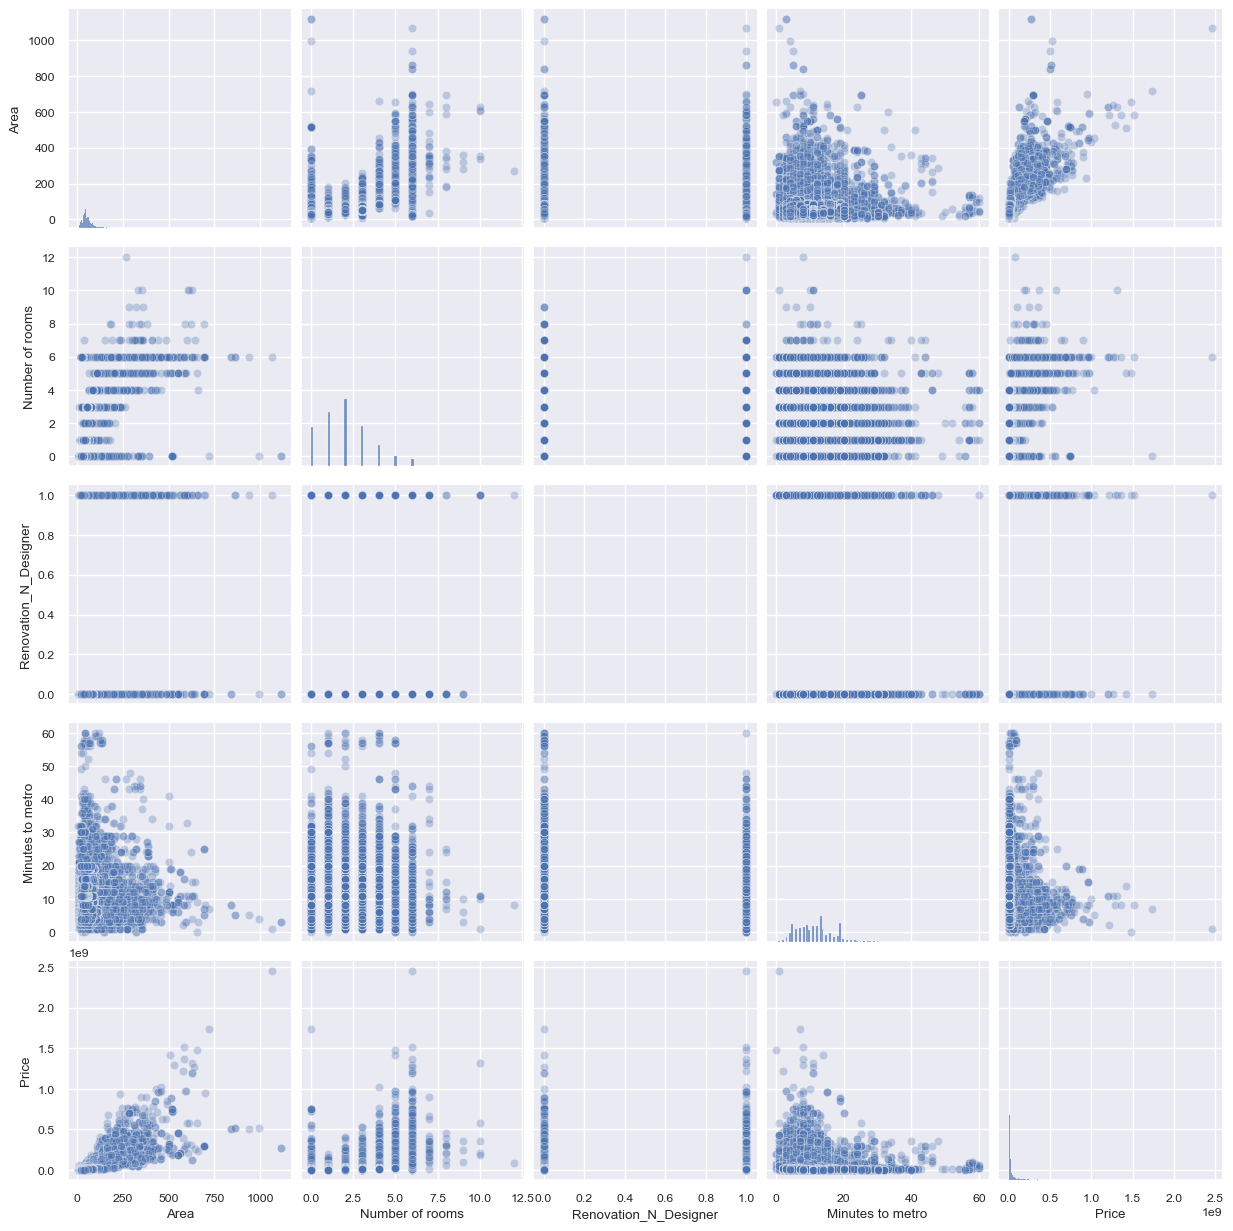

In [201]:
# График признаков попарно
plt.figure(figsize=(7,7))
%config InlineBackend.figure_format = 'png' # формат изображений PNG, для сокращения времени отрисовки графиков

sns.pairplot(
    df_digital[features3 + target],
    #hue = 'Type',         # Признак разделения
    kind="scatter",        # Тип даграмм: reg,scatter
    diag_kind = 'hist',     # Тип диагоральных даграмм: hist, kde
    plot_kws={'alpha':0.3} # прозрачность точек
);

## Поиск и обработка выбросов

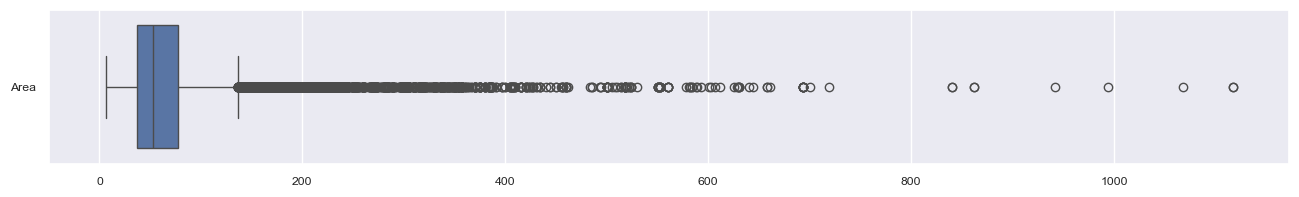

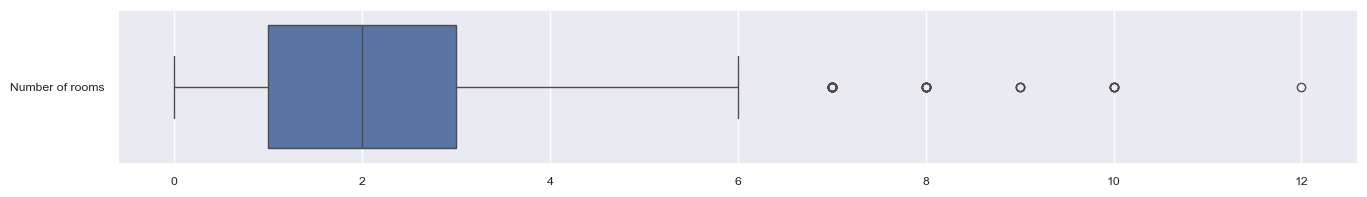

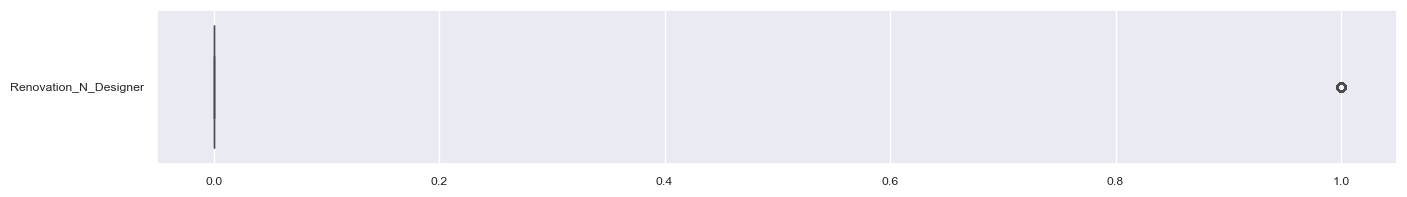

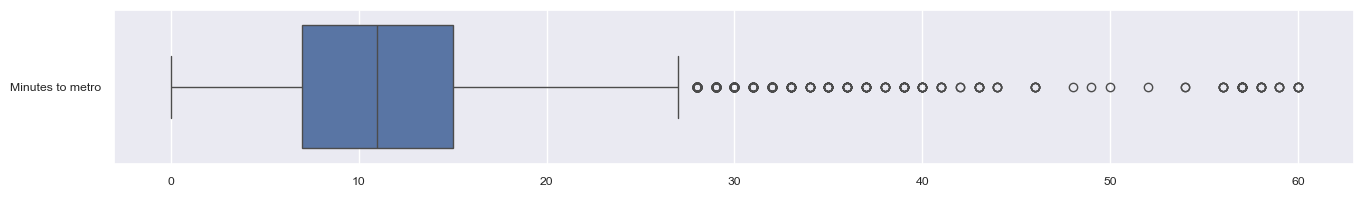

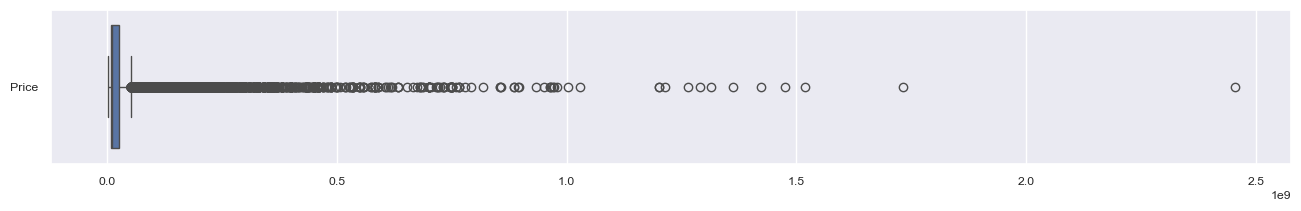

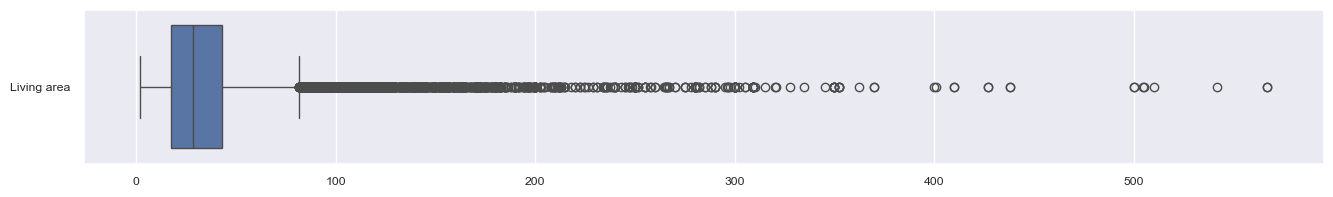

In [202]:
# Цикл: для каждого элемента в объединенном списке
for feature_name in (features3+target+['Living area']):

    # Построить полотно для рисования с указанным размером
    plt.figure(figsize=(16,2))

    # На созданном полотне отрисовать boxplot
    sns.boxplot( data=df_digital[[feature_name]], # данные
                    orient='h' # ориентация графика
                    )

Установим границы значений, для тех объектов таблицы, которые должны остаться

Межквартильный размах (IQR)
Это мера разброса данных, которая показывает диапазон центральных 50% значений. Он вычисляется по формуле:

IQR=Q3−Q1

Q1 — это первый квартиль (25-й процентиль), значение, ниже которого находится 25% всех данных.

Q3 — это третий квартиль (75-й процентиль), значение, ниже которого находится 75% всех данных.

Формулы для усов и выбросов
Наиболее распространённый метод построения усов (метод Тьюки) основан на IQR. Он помогает выявить потенциальные выбросы, то есть значения, которые значительно отличаются от основной массы данных.

Формулы для границ:

Нижняя граница уса: Q1−1.5×IQR

Верхняя граница уса: Q3+1.5×IQR

Как это работает:

Нижний ус простирается от Q1 до самого маленького значения в наборе данных, которое больше или равно нижней границе. Если таких значений нет, то ус доходит до минимального значения в наборе.

Верхний ус простирается от Q3 до самого большого значения, которое меньше или равно верхней границе. Если таких значений нет, то ус доходит до максимального значения.

In [203]:
# создадим "словарь"/"хэш-таблицу" для удобного обращения, где ключ - это название признака
cols = ['Price', 'Area', 'Living area', 'Number of rooms', 
        'Renovation_N_Designer', 'Minutes to metro']


for col in cols:
        Q1 = df_digital[col].quantile(0.25)
        Q3 = df_digital[col].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 3 * IQR #более мягкие границы: вместо 1.5 * IQR берём 3 * IQR.

        print(f"{col} = ({lower:.2f}, {upper:.2f})")

Price = (-19463314.88, 77809279.50)
Area = (-22.21, 196.36)
Living area = (-20.80, 120.00)
Number of rooms = (-2.00, 9.00)
Renovation_N_Designer = (0.00, 0.00)
Minutes to metro = (-5.00, 39.00)


In [226]:
# создадим "словарь"/"хэш-таблицу" для удобного обращения, где ключ - это название признака
tressholdDict = {
    'Price'                     : (0,100000000),
    'Area'                      : (0,196.36),
    'Living area'               : (0, 120),
    'Number of rooms'           : (0, 6),
    'Renovation_N_Designer'     : (0, 1),
    'Minutes to metro'          : (0, 39),
}

print (tressholdDict)

{'Price': (0, 100000000), 'Area': (0, 196.36), 'Living area': (0, 120), 'Number of rooms': (0, 6), 'Renovation_N_Designer': (0, 1), 'Minutes to metro': (0, 39)}


Проверим, какая часть данных выходит за пределы границ значений

In [227]:
# Цикл: для каждого элемента в словаре/хэш-таблице пройтись по ключам - названиям признаков
for feature_name  in tressholdDict:
    threesMin =  tressholdDict[feature_name][0] # извлечь нижнее пороговое
    tresshMax =  tressholdDict[feature_name][1] # извлечь верхнее пороговое

    # Получить кол-во эл. вне пороговых значений. Прием - фильтрация
    over_count = len(  df_digital[
                            ~((df_digital[feature_name] >= threesMin ) & (df_digital[feature_name] <= tresshMax)) # фильтр по двум границам. ~ инверсия логических значений
                            ]
                    )

    dcount = df_digital[feature_name].count() # кол-во эл. общее

    print ('''{}. Принимаем пороговые значение равными {}.
        Кол-во эл. вне пороговых - {} из {} значение(ий) ({:.1%})\n'''.format(
        feature_name,
        tressholdDict[feature_name],
        over_count,
        dcount,
        over_count/ dcount,
    ))

Price. Принимаем пороговые значение равными (0, 100000000).
        Кол-во эл. вне пороговых - 1864 из 22656 значение(ий) (8.2%)

Area. Принимаем пороговые значение равными (0, 196.36).
        Кол-во эл. вне пороговых - 1158 из 22656 значение(ий) (5.1%)

Living area. Принимаем пороговые значение равными (0, 120).
        Кол-во эл. вне пороговых - 879 из 22656 значение(ий) (3.9%)

Number of rooms. Принимаем пороговые значение равными (0, 6).
        Кол-во эл. вне пороговых - 46 из 22656 значение(ий) (0.2%)

Renovation_N_Designer. Принимаем пороговые значение равными (0, 1).
        Кол-во эл. вне пороговых - 0 из 22656 значение(ий) (0.0%)

Minutes to metro. Принимаем пороговые значение равными (0, 39).
        Кол-во эл. вне пороговых - 72 из 22656 значение(ий) (0.3%)



In [229]:
# Во избежание путаницы создадим для полседующих операций копию исходного объетка
df_digPlusFiltred = df_digital.copy()

for feature_name  in tressholdDict:
    threesMin =  tressholdDict[feature_name][0]
    tresshMax =  tressholdDict[feature_name][1]


    # фильтр по двум границам. Оператор "~" -инверсия логических значений
    df_digPlusFiltred = df_digPlusFiltred[
        (df_digPlusFiltred[feature_name] >= threesMin ) & (df_digPlusFiltred[feature_name] <= tresshMax)
        ]
    print("Обработан ", feature_name )


print ("Отброшено {} строк. Осталось {} строк.".format(
    len(df_digital)  - len(df_digPlusFiltred),
    len(df_digPlusFiltred))
)

Обработан  Price
Обработан  Area
Обработан  Living area
Обработан  Number of rooms
Обработан  Renovation_N_Designer
Обработан  Minutes to metro
Отброшено 2118 строк. Осталось 20538 строк.


Area 6.0 195.8
Number of rooms 0.0 6.0
Renovation_N_Designer 0 1
Minutes to metro 0.0 39.0
Price 1150000.0 100000000.0
Living area 2.0 120.0


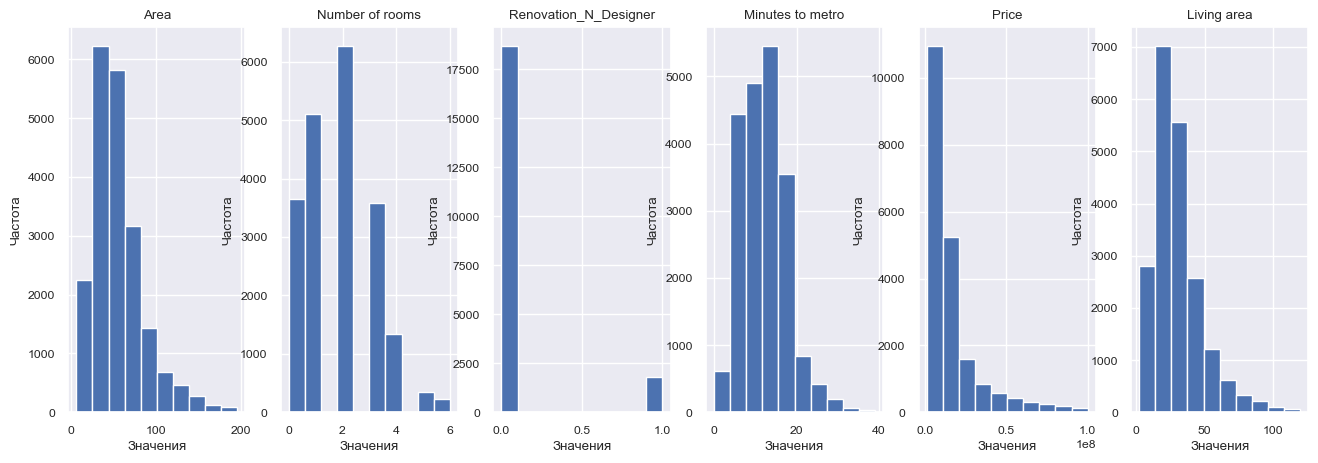

In [230]:
# Строим гистограммы по каждому признаку:
# data[features].hist() #Упрощенный вывод графиков

plt.figure(figsize=(16, 5))
plot_number = 0

for feature_name in (features3+target+['Living area']):
    plot_number += 1

    plt.subplot(1, len(features3+target+['Living area']), plot_number)

    plt.hist(df_digPlusFiltred[feature_name]) # Построение гистрограммы

    plt.title(feature_name)
    plt.xlabel(u'Значения')
    plt.ylabel(u'Частота')
    print (feature_name,
            df_digPlusFiltred[feature_name].min(),
            df_digPlusFiltred[feature_name].max())

## Сохранение данных

In [232]:
df_digPlusFiltred.to_csv('../Data/Moscow_Housing_Price_Dataset_nan_24_PREPARED.csv', # путь для сохранения
            index=False, # запрет сохранения "индексов" (тек. номеров строк)
)

## Формирование тренировочной и проверочной выборок

In [238]:
valid_size = 0.3 # доля тестовой части в выборке
rand_seed = 8 # начальное состояние генератора случ. чисел

x_train, x_test, y_train, y_test =  train_test_split(
    df_digPlusFiltred[features3+['Living area']],   # исходные данные X
    df_digPlusFiltred[target],      # исходные данные y

    test_size = valid_size, # доля тестовой части в выборке
    random_state=rand_seed, # начальное состояние генератора случ. чисел
    shuffle=True            # перемешивание
)

In [239]:
print ("Кол-во элементов: \n  x_train: {}, y_train {} \n  x_test:  {}, y_test  {} \n  total x: {}, total y {} ".format  (
    len(x_train), len(y_train),
    len(x_test),  len(y_test),
    len(x_train)+len(x_test), len(y_train)+len(y_test),
))

Кол-во элементов: 
  x_train: 14376, y_train 14376 
  x_test:  6162, y_test  6162 
  total x: 20538, total y 20538 


In [240]:
x_test[:3]

,Area,Number of rooms,Renovation_N_Designer,Minutes to metro,Living area
21118,60.6,2.0,0,9.0,32.8
22409,40.5,2.0,0,11.0,27.2
2995,44.1,0.0,1,10.0,30.1


# Построение модели 1

In [241]:
model_Area = linear_model.LinearRegression()

In [242]:
# Вычислить коэфф. Ki в функции y(x)=Ki*xi + .... + B
# на тренировочном наборе, т.е. обучить модель
model_Area.fit(
    x_train[['Area']],
    y_train[['Price']]
)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [243]:
# Получить вычисленные(predicted) зн. на проверочном наборе
# y_pred = fittedModel.predict(x_test)
y_predicted_on_Area = model_Area.predict(x_test[['Area']])

## Функции для построения графиков

In [244]:
def PLOTSCATTER(x_train, y_train, x_test, y_test, y_pred, model) -> None:
    '''
    Функция построения графиков
    :param y_test: - проверочные значения целевой переменной
    :param y_pred: - вычисленные значения целевой переменной
    '''
    # Создать полотно для рисования с указаными размерами
    plt.figure(figsize=(15,5))

    # Точечная диаграмма (диаграмма рассеяния) - plt.scatter
    plt.scatter(x_train,  y_train, alpha=0.3, label='Тренировочный') # тренировочный
    plt.scatter(x_test,   y_test,  alpha=0.3, label='Проверочный')   # проверочный

    # Нанести график - линии, проведённые через точки - plt.plot
    plt.scatter( x_test, y_pred,
            lw=2, color='red',
            label="y_pred (X) = x0 * {:.3f} + {:.3f}".format(model.coef_[0][0], model.intercept_[0]))
    plt.grid(True)  # Сетка. Доп параметры color='black', linewidth=0.7
    plt.legend(loc="best")  # Положение легенды
    plt.xlabel('Плотность') # Подпись осей
    plt.ylabel(target[0])   # Подпись осей
    plt.title(u'График разброса'); # Заголовок

def PLOTHIST(y_test, y_pred) -> None:
    '''
    Функция построения графиков
    :param y_test: - проверочные значения целевой переменной
    :param y_pred: - вычисленные значения целевой переменной
    '''
    plt.figure(figsize=(6,4))

    # Гистограмма и Плотность распределения - sns.distplot
    # data = y_true - y_pred
    sns.histplot( data = y_test - y_pred,
                color="red",
                kde=True, # оценка плотности в виде кривой
                stat="density",# density: общая площадь равна 1
                )

    # Осевая линия
    plt.plot(
        [0, 0],
        [0, 10 * pow(10,-7)], '--', lw=2, c='r')

    plt.ylabel(u'Плотность')
    plt.xlabel(u'Значение ошибки')
    plt.title(u'Плотность распределения и гистограмма ошибок');
    plt.show()

def PLOT34(y_test, y_pred) -> None:
    '''
    Функция построения графиков
    :param y_test: - проверочные значения целевой переменной
    :param y_pred: - вычисленные значения целевой переменной
    '''
    plt.figure(figsize=(12,6))

    # == Диаграмма рассеяния вычисленных значений ==
    # создать первое полотно 121: 1-строк, 2-столбцов, 1-индекс текущего полотна в сетке
    plt.subplot(121)
    plt.scatter(y_test, y_pred,  alpha=0.1, color = "#17becf")
    plt.plot(  [ np.min(y_test), np.max(y_test) ], # x1,x2
               [ np.min(y_test), np.max(y_test) ], # y1,y2
               '--',
               alpha=0.7, lw=3, color = "black")
    plt.title('Диаграмма рассеяния вычисленных значений');
    plt.xlabel('Проверочное Y')
    plt.ylabel('Вычисленное Y')
    plt.grid(True)  # Сетка. Доп параметры color='black', linewidth=0.7

    # == Диаграмма рассеяния ошибок ==
    # создать второе полотно 121: 1-строк, 2-столбцов, 2-индекс текущего полотна в сетке
    plt.subplot(122)
    plt.scatter(y_test, (y_test - y_pred)**2,  alpha=0.1, color = "#17becf")
    plt.title('Диаграмма рассеяния квадрата абсолютной ошибки')
    plt.xlabel('Проверочное Y')
    plt.ylabel('Квадрат абсолютной ошибки')
    plt.grid(True)  # Сетка. Доп параметры color='black', linewidth=0.7
#--------------------------------------------------------------------------

def PRINTR2(model, y_test, y_pred) -> None:
    '''
    Функция построения графиков
    :param y_test: - проверочные значения целевой переменной
    :param y_pred: - вычисленные значения целевой переменной
    '''
    print ("Линейная одномерная регрессия.")
    print ("Формула линейной регресси y(X) = k0*x0 + ... kN*xN + b")
    print(f"y = f(X) = ")
    for i, kN in enumerate (model.coef_[0]):
        print(f" {' ' if i==0 else '+'}  {kN:.3f} * x{i} ")
    print(f"+ {model.intercept_[0]:.3f} ")
    print("\n")

    '''
    Вычисление и вывод метрик: MAE, RMSE, R2.
    На основе сравнения проверочных и вычисленных.
    '''
    mae  = metrics.mean_absolute_error(y_test, y_pred)
    mse  = metrics.mean_squared_error (y_test, y_pred)
    rmse = np.sqrt(mse)
    r2   = metrics.r2_score           (y_test, y_pred)
    print ("MAE : {:>9,.3f} (средняя абсолютная ошибка)".format( mae ))
    print ("MSE : {:>9,.6f} (среднеквадратичная ошибка)".format( mse ))
    print ("RMSE: {:>9,.6f} (кв. корень из среднеквадратичной ошибки)".format( rmse ))
    print ("R2  : {:>9,.3f} (коэфф. детерминации)".format      ( r2 ))

### Графики для модели 1

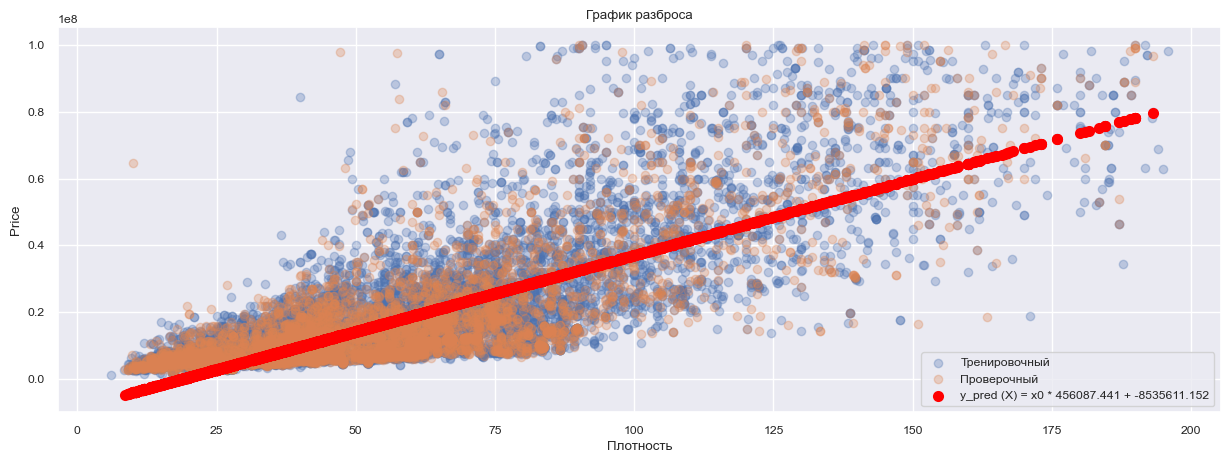

In [245]:
PLOTSCATTER(
    x_train = x_train[['Area']],
    y_train = y_train[['Price']],
    x_test = x_test[['Area']],
    y_test = y_test[['Price']],
    y_pred = y_predicted_on_Area,
    model = model_Area
)

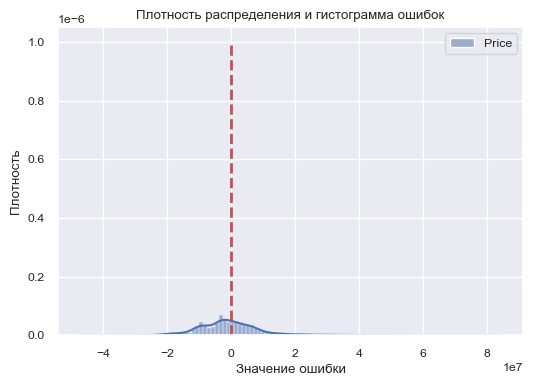

In [246]:
PLOTHIST(
    y_test = y_test[['Price']],
    y_pred = y_predicted_on_Area
)

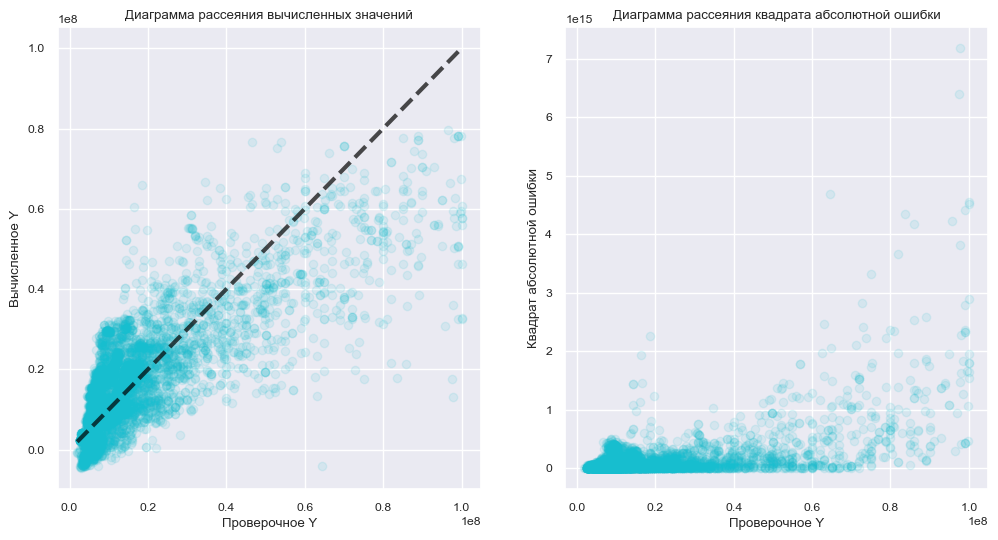

In [247]:
PLOT34(
    y_test = y_test[['Price']],
    y_pred = y_predicted_on_Area
)

In [248]:
PRINTR2(
    model = model_Area,
    y_test = y_test,
    y_pred = y_predicted_on_Area
)

Линейная одномерная регрессия.
Формула линейной регресси y(X) = k0*x0 + ... kN*xN + b
y = f(X) = 
    456087.441 * x0 
+ -8535611.152 


MAE : 7,376,061.655 (средняя абсолютная ошибка)
MSE : 110,668,854,300,551.625000 (среднеквадратичная ошибка)
RMSE: 10,519,926.534941 (кв. корень из среднеквадратичной ошибки)
R2  :     0.613 (коэфф. детерминации)


### Многомерная модель от 2 набора переменных

In [249]:
features2

['Living area', 'Number of rooms', 'Renovation_N_Designer']

In [250]:
model_LA_NR_RnD = linear_model.LinearRegression()

In [251]:
model_LA_NR_RnD.fit(
    x_train[features2],
    y_train[['Price']]
)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [252]:
# Получить вычисленные(predicted) зн. на проверочном наборе
# y_pred = fittedModel.predict(x_test)
y_predicted_on_LA_NR_RnD = model_LA_NR_RnD.predict(x_test[features2])

### Графики для 2 модели

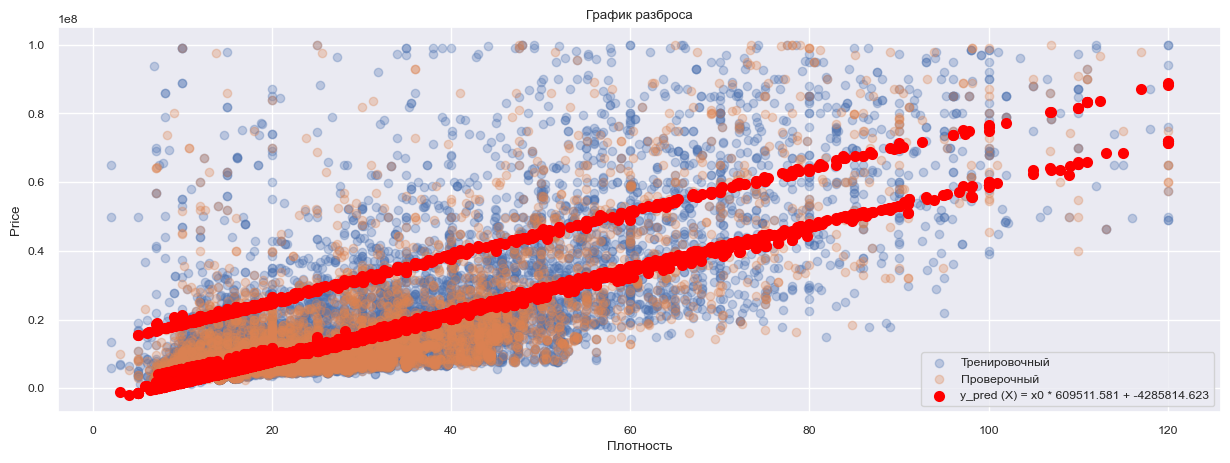

In [253]:
PLOTSCATTER(
    x_train = x_train[['Living area']],
    y_train = y_train[['Price']],
    x_test = x_test[['Living area']],
    y_test = y_test[['Price']],
    y_pred = y_predicted_on_LA_NR_RnD,
    model = model_LA_NR_RnD
)

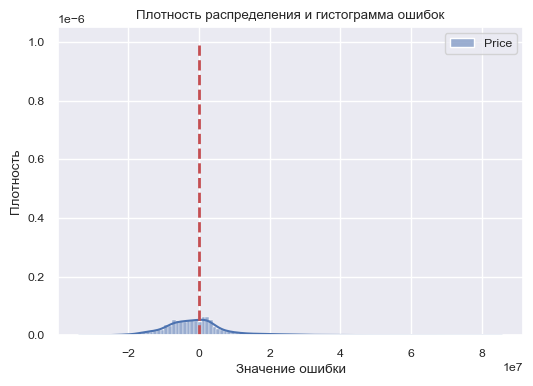

In [254]:
PLOTHIST(
    y_test = y_test[['Price']],
    y_pred = y_predicted_on_LA_NR_RnD
)

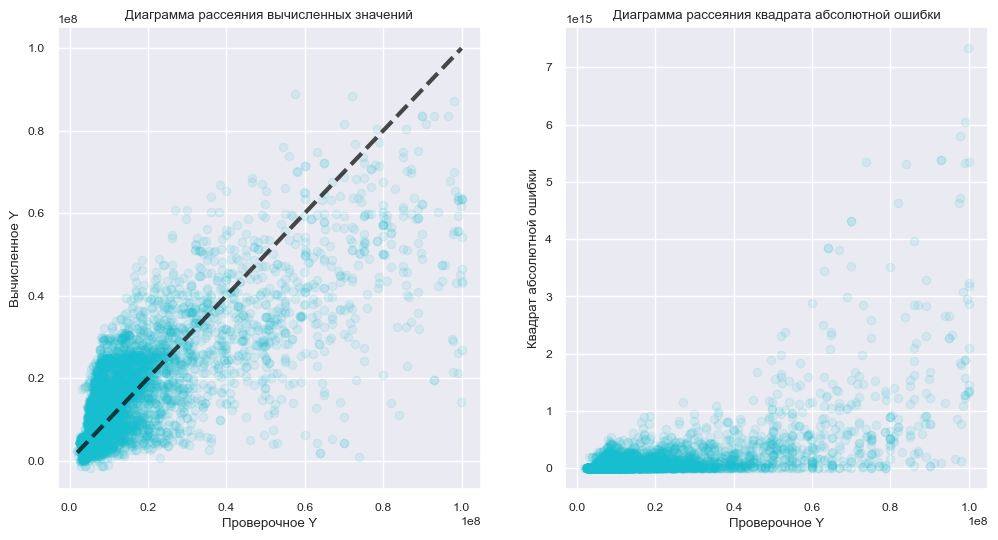

In [255]:
PLOT34(
    y_test = y_test[['Price']],
    y_pred = y_predicted_on_LA_NR_RnD
)

In [257]:
PRINTR2(
    model = model_LA_NR_RnD,
    y_test = y_test,
    y_pred = y_predicted_on_LA_NR_RnD
)

Линейная одномерная регрессия.
Формула линейной регресси y(X) = k0*x0 + ... kN*xN + b
y = f(X) = 
    609511.581 * x0 
 +  651830.074 * x1 
 +  16853677.509 * x2 
+ -4285814.623 


MAE : 7,354,688.643 (средняя абсолютная ошибка)
MSE : 121,215,601,109,035.828125 (среднеквадратичная ошибка)
RMSE: 11,009,795.688796 (кв. корень из среднеквадратичной ошибки)
R2  :     0.576 (коэфф. детерминации)


### Многомерная модель от 3 набора переменных

In [258]:
features3

['Area', 'Number of rooms', 'Renovation_N_Designer', 'Minutes to metro']

In [259]:
model_A_NR_RnD_MtM = linear_model.LinearRegression()

In [260]:
model_A_NR_RnD_MtM.fit(
    x_train[features3],
    y_train[['Price']]
)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [261]:
# Получить вычисленные(predicted) зн. на проверочном наборе
# y_pred = fittedModel.predict(x_test)
y_predicted_on_A_NR_RnD_MtM = model_A_NR_RnD_MtM.predict(x_test[features3])

### Графики для 3 модели

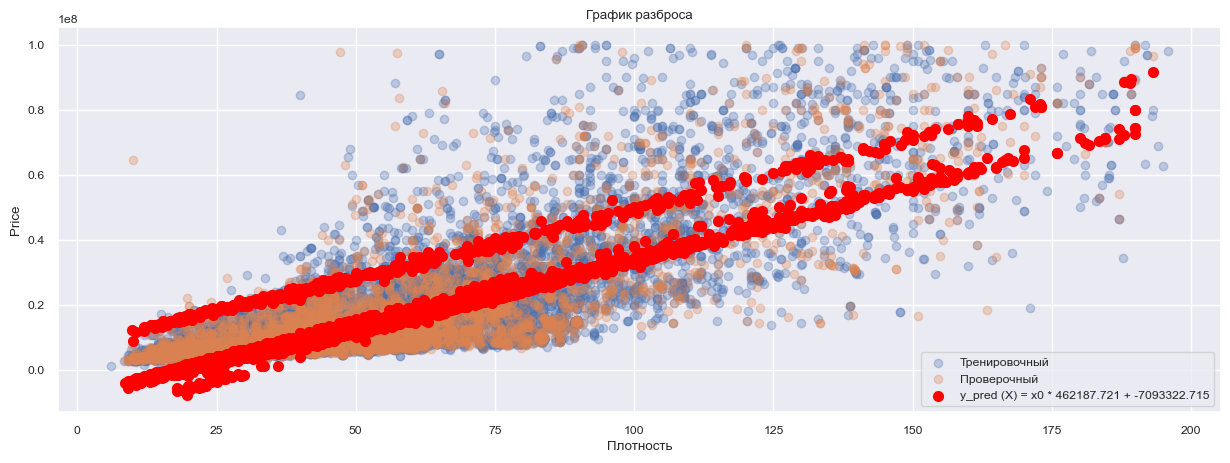

In [262]:
PLOTSCATTER(
    x_train = x_train[['Area']],
    y_train = y_train[['Price']],
    x_test = x_test[['Area']],
    y_test = y_test[['Price']],
    y_pred = y_predicted_on_A_NR_RnD_MtM,
    model = model_A_NR_RnD_MtM
)

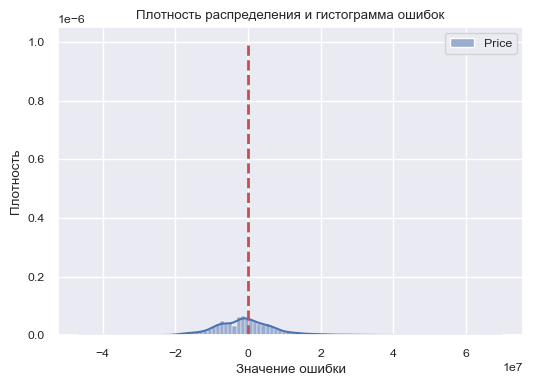

In [263]:
PLOTHIST(
    y_test = y_test[['Price']],
    y_pred = y_predicted_on_A_NR_RnD_MtM
)

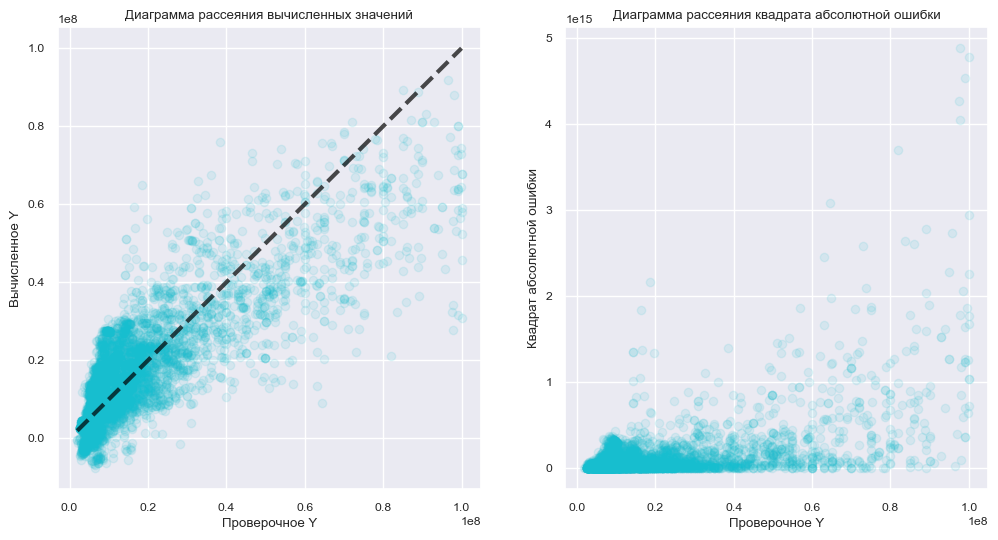

In [264]:
PLOT34(
    y_test = y_test[['Price']],
    y_pred = y_predicted_on_A_NR_RnD_MtM
)

In [265]:
PRINTR2(
    model = model_A_NR_RnD_MtM,
    y_test = y_test,
    y_pred = y_predicted_on_A_NR_RnD_MtM
)

Линейная одномерная регрессия.
Формула линейной регресси y(X) = k0*x0 + ... kN*xN + b
y = f(X) = 
    462187.721 * x0 
 +  -1128276.021 * x1 
 +  15184191.017 * x2 
 +  -94219.236 * x3 
+ -7093322.715 


MAE : 6,825,454.053 (средняя абсолютная ошибка)
MSE : 94,827,615,173,047.250000 (среднеквадратичная ошибка)
RMSE: 9,737,947.174484 (кв. корень из среднеквадратичной ошибки)
R2  :     0.668 (коэфф. детерминации)


# Итоги. Сравнение полученных моделей

Исходный размер:
(22676, 12)
Итого: 22676 записи, 12 столбец (признак).

In [268]:
print("Размер исходного DataFrame", df.shape)
print ("Отброшено {} строк. Осталось после фильтрации {} строк.".format(
    len(df_digital)  - len(df_digPlusFiltred),
    len(df_digPlusFiltred))
)

Размер исходного DataFrame (22656, 18)
Отброшено 2118 строк. Осталось после фильтрации 20538 строк.


In [269]:
print("\nПервая модель\n")
PRINTR2(
    model = model_Area,
    y_test = y_test,
    y_pred = y_predicted_on_Area
)
print("\nВторая модель\n")
PRINTR2(
    model = model_LA_NR_RnD,
    y_test = y_test,
    y_pred = y_predicted_on_LA_NR_RnD
)
print("\nТретья модель\n")
PRINTR2(
    model = model_A_NR_RnD_MtM,
    y_test = y_test,
    y_pred = y_predicted_on_A_NR_RnD_MtM
)


Первая модель

Линейная одномерная регрессия.
Формула линейной регресси y(X) = k0*x0 + ... kN*xN + b
y = f(X) = 
    456087.441 * x0 
+ -8535611.152 


MAE : 7,376,061.655 (средняя абсолютная ошибка)
MSE : 110,668,854,300,551.625000 (среднеквадратичная ошибка)
RMSE: 10,519,926.534941 (кв. корень из среднеквадратичной ошибки)
R2  :     0.613 (коэфф. детерминации)

Вторая модель

Линейная одномерная регрессия.
Формула линейной регресси y(X) = k0*x0 + ... kN*xN + b
y = f(X) = 
    609511.581 * x0 
 +  651830.074 * x1 
 +  16853677.509 * x2 
+ -4285814.623 


MAE : 7,354,688.643 (средняя абсолютная ошибка)
MSE : 121,215,601,109,035.828125 (среднеквадратичная ошибка)
RMSE: 11,009,795.688796 (кв. корень из среднеквадратичной ошибки)
R2  :     0.576 (коэфф. детерминации)

Третья модель

Линейная одномерная регрессия.
Формула линейной регресси y(X) = k0*x0 + ... kN*xN + b
y = f(X) = 
    462187.721 * x0 
 +  -1128276.021 * x1 
 +  15184191.017 * x2 
 +  -94219.236 * x3 
+ -7093322.715 


MAE 

Оцените в минутах время затраченное на выполнение основных этапов текущей работы, согласно методологии CRISP, затем заполните эту информацию в следующей ячейке для получения столбчатой диаграммы.

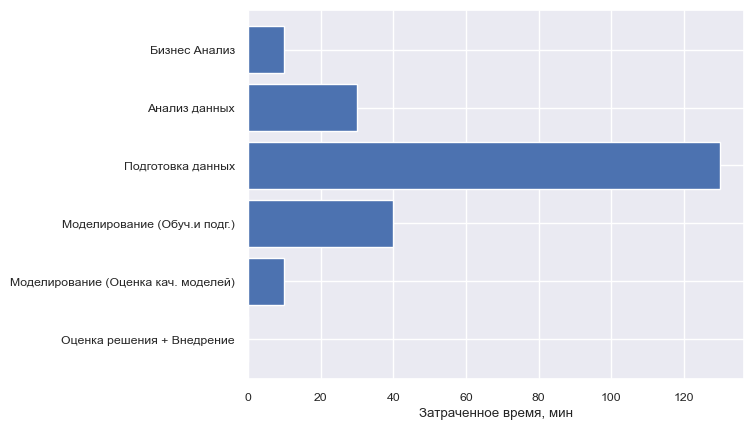

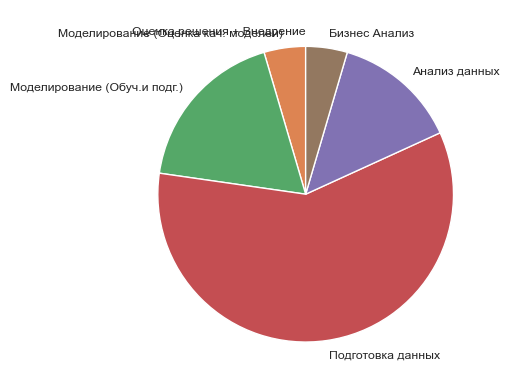

In [270]:
# Создадим датафрейм для хранения значений
dfSpendTimeLab1 = pd.DataFrame.from_dict(
{
    "1": {"step": "Бизнес Анализ",                       "duration, min" : 10  },  # понимание задачи
    "2": {"step": "Анализ данных",                       "duration, min" : 30  },  # загрузка + первичный осмотр
    "3": {"step": "Подготовка данных",                   "duration, min" : 130 },  # фильтрация (40) + кодирование (60) + мелкие доработки (30)
    "4": {"step": "Моделирование (Обуч.и подг.)",        "duration, min" : 40  },  # обучение моделей и графики
    "5": {"step": "Моделирование (Оценка кач. моделей)", "duration, min" : 10  },  # метрики, сравнение
    "6": {"step": "Оценка решения + Внедрение",          "duration, min" : 0  },  # выводы и оформление
}
, orient="index"
).sort_index(ascending=False)

# Построить столбчатую диаграмму
fig = plt.figure()
plt.barh(y = dfSpendTimeLab1["step"], width= dfSpendTimeLab1["duration, min"], )
plt.xlabel("Затраченное время, мин")

# Построить круговую диаграмму
fig = plt.figure()
plt.pie(x= dfSpendTimeLab1["duration, min"], labels=dfSpendTimeLab1["step"],  startangle = 90 )

plt.show()

# Выводы по работе

Сравните модели между собой по метрике точности R2:
- какая из полученных моделей имеет макс. значение метрики R2?
- во сколько раз метрики R2 отличаются между моделями?
- какие из выбранных признаков X являются необходимыми для увеличения R2?
- как изменяется метрика R2 при дополнении одних признаков X другими?

### 1. Сравнение моделей по метрике R²
| Модель | Признаки X | R² |
|--------|------------|----|
| Модель 1 | ['Area'] | 0.613 |
| Модель 2 | ['Living area', 'Number of rooms', 'Renovation_N_Designer'] | 0.576 |
| Модель 3 | ['Area', 'Number of rooms', 'Renovation_N_Designer', 'Minutes to metro'] | 0.668 |

- **Максимальное значение R²** = 0.668 у **Модели 3** → эта модель объясняет наибольшую долю дисперсии цены.
- **Сравнение R² между моделями**:  
  - Модель 3 / Модель 1 ≈ 1.09 → улучшение R² на ~9%  
  - Модель 3 / Модель 2 ≈ 1.16 → улучшение R² на ~16%  

---

### 2. Влияние признаков на R²
- **Area** является сильным и необходимым признаком:  
  - Модель 1 с одним признаком `Area` имеет R² = 0.613.  
  - Добавление других признаков к Area (Модель 3) увеличивает R² до 0.668.  

- **Living area, Number of rooms, Renovation_N_Designer** (Модель 2) без Area дают R² = 0.576 → меньше, чем модель с одним Area.  
  - Значит, Area содержит ключевую информацию о цене.

- **Minutes to metro** добавлен в Модель 3, но влияние на R² незначительное (0.668 vs 0.613 с Area + другие признаки).  

---

### 3. Как изменяется R² при дополнении признаков
- Модель 1 → 1 признак → R² = 0.613  
- Модель 2 → 3 признака без Area → R² = 0.576 (ниже, чем у одного сильного признака)  
- Модель 3 → комбинация признаков с Area → R² = 0.668 (лучший результат)  

**Вывод:**  
- Для увеличения точности модели (R²) **ключевым является Area**.  
- Дополнение другими признаками (Number of rooms, Renovation_N_Designer, Minutes to metro) немного улучшает R², но их влияние вторично.  
- Удаление Area резко снижает качество модели, даже если добавить несколько других признаков.  


